In [1]:
import math
import random
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def calV_3D(N, ens, mc, S_array):
  '''
  We calculate the diversity of group opinions using the function calV_3D,
  which yields a value analogous to electric potential energy.
  A higher energy value indicates greater diversity among the group opinions.
  '''

  # Choose the V_max considering group size (N); these values are maximum PE of N-system, respectively.
  V_max_list = np.array([1.4142135623730951, 3.9481594714802353, 7.666977259633668, 12.49614444572656, 18.511218397802732, 25.619490892577677, 33.89610553620064, 43.30531859956281, 53.851507919120344])
  V_max = V_max_list[N-2]

  # Calculate V (mass of external field)
  V = 0
  for i in range(N):
    for j in range(N):
      if i == j:
        continue
      a = S_array[mc,ens,i,:]
      b = S_array[mc,ens,j,:]
      cos_t = np.round(np.dot(a, b),10)
      t = (2-2*cos_t)**0.5
      V += t**0.5

  return 0.5*V/V_max

In [3]:
def run(Sarray, N, T, alpha, ENS_step, MC_step):
  '''
  N =         No. of agents
  alpha =     Exponent
  ENS_step =  Ensemble
  MC_step =   (Macro) Step
  '''
  S_array = np.zeros((MC_step, ENS_step, N, 3))
  S_array[0] = Sarray[0]
  V_array = np.zeros((MC_step, ENS_step))           # V(t)

  for mc in range(MC_step):
    for ens in range(ENS_step):

      # 1. Initialize
      if mc == 0:
        V_array[mc,ens] = calV_3D(N, ens, mc, S_array)

      # 2. Interact
      else:
        V = V_array[mc-1,ens]
        for i in range(N):
          # 1. Calculate Group Opinion (S_G)
          e = np.array([0.0, 0.0, 1.0])
          v_i = np.array([0.0, 0.0, 0.0])
          for j in range(N):
            si_sj = np.dot(S_array[mc-1,ens,i,:], S_array[mc-1,ens,j,:])
            v_ij = 0.5*(1+si_sj)*S_array[mc-1,ens,j,:]
            v_i += v_ij
          v_i += (N**alpha)*V*e
          v_i_n = np.linalg.norm(v_i)
          v_f = v_i/v_i_n

          # 2. Calculate Prob
          if mc <= T:
            rT = np.sum(S_array[0:mc,ens,i,:], axis=0)
          else:
            rT = np.sum(S_array[mc-T:mc,ens,i,:], axis=0)
          M = np.linalg.norm(rT)
          Th = np.arccos(np.round(np.dot(rT/M, v_f),10))
          Lamb = 1/(1+M*Th)

          # 3. Spin
          p = np.random.rand()
          # 3-1. Change Spins
          if p <= Lamb:
            S_array[mc,ens,i,:] = v_f
          # 3-2. Retain Spins
          else:
            S_array[mc,ens,i,:] = S_array[mc-1,ens,i,:]
          V_array[mc,ens] = calV_3D(N, ens, mc, S_array)

  return S_array, V_array

# Data generation

In 'DataGen_FigAll.ipynb', we generated only the initial configurations of the spins.

The following code runs the system until the final time step $t=t_f$.

In [4]:
N = 4
T = 10
alpha = 0.5
MC_step = 100+1
ENS_step = 1000

V_tar_lst = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
Score_lst = [-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5]

Savg_df = np.zeros((len(V_tar_lst), len(Score_lst)))
Sstd_df = np.zeros((len(V_tar_lst), len(Score_lst)))
Vavg_df = np.zeros((len(V_tar_lst), len(Score_lst)))
Vstd_df = np.zeros((len(V_tar_lst), len(Score_lst)))

for v, V_tar in enumerate(V_tar_lst):
  for s, Score_tar in enumerate(Score_lst):
    S_array = []
    V_array = []

    with open(f"Sarray_N{N}_Score{Score_tar}_Vt{V_tar}.pkl","rb") as f:
        Sarray = pickle.load(f)
        
    S_array, V_array = run(Sarray, N, T, alpha, ENS_step, MC_step)
    
    Savg_df[v, s] = S_array[-1, :, :,2].mean(1).mean()
    Sstd_df[v, s] = np.std(S_array[-1, :, :,2].mean(1))/(ENS_step**0.5)
    Vavg_df[v, s] = V_array[-1,:].mean()
    Vstd_df[v, s] = np.std(V_array[-1,:].mean())/(ENS_step**0.5)
    


with open(f"Savg.pkl","wb") as f:
    pickle.dump(Savg_df, f)
with open(f"Sstd.pkl","wb") as f:
    pickle.dump(Sstd_df, f)
with open(f"Vavg.pkl","wb") as f:
    pickle.dump(Vavg_df, f)
with open(f"Vstd.pkl","wb") as f:
    pickle.dump(Vstd_df, f)

KeyboardInterrupt: 

In [5]:
with open(f"Savg.pkl","rb") as f:
    Savg_df = pickle.load(f)
with open(f"Sstd.pkl","rb") as f:
    Sstd_df = pickle.load(f)
with open(f"Vavg.pkl","rb") as f:
    Vavg_df = pickle.load(f)
with open(f"Vstd.pkl","rb") as f:
    Vstd_df = pickle.load(f)

In [6]:
Savg_df

array([[-0.43919465, -0.32835643, -0.21626065, -0.12422205, -0.02313782,
         0.07105387,  0.17271419,  0.26576251,  0.3590978 ,  0.44917902,
         0.54318484],
       [-0.30611143, -0.1537108 , -0.0428885 ,  0.03954881,  0.13245554,
         0.21226251,  0.29883063,  0.36540722,  0.44233598,  0.52014684,
         0.59572181],
       [-0.04966655,  0.08457241,  0.13757945,  0.23857972,  0.28969519,
         0.37517027,  0.41915377,  0.47053308,  0.54063604,  0.59440265,
         0.65047836],
       [ 0.36719204,  0.46729121,  0.49989451,  0.53023205,  0.58005378,
         0.58533993,  0.63704338,  0.65321524,  0.68601406,  0.71414538,
         0.75079856],
       [ 0.62857963,  0.63892333,  0.66433518,  0.67743984,  0.69115151,
         0.70785162,  0.72179643,  0.75531916,  0.76531037,  0.77985617,
         0.80645953],
       [ 0.7198822 ,  0.74207223,  0.75251008,  0.75867416,  0.76916121,
         0.78395898,  0.78200974,  0.79145102,  0.81509264,  0.82995407,
         0.859

In [7]:
Sstd_df

array([[0.00441986, 0.00490961, 0.00535538, 0.0041559 , 0.0039383 ,
        0.00305926, 0.00305297, 0.00236679, 0.00196502, 0.00118995,
        0.00085802],
       [0.00997554, 0.01120115, 0.01068756, 0.00926456, 0.00833311,
        0.00721259, 0.00623391, 0.00470098, 0.00358823, 0.00267626,
        0.00166833],
       [0.01553159, 0.01451075, 0.01270468, 0.01157892, 0.00992414,
        0.00876938, 0.00713072, 0.00569992, 0.00459314, 0.00337578,
        0.00215815],
       [0.01579561, 0.01366383, 0.01200848, 0.01072518, 0.00911877,
        0.0080069 , 0.00665623, 0.0055995 , 0.0044384 , 0.00347687,
        0.00249655],
       [0.01093171, 0.00994966, 0.00847315, 0.00748896, 0.00667183,
        0.00572143, 0.00493238, 0.00397453, 0.00328802, 0.0026978 ,
        0.00203948],
       [0.00714374, 0.00569816, 0.00526087, 0.00476824, 0.00400891,
        0.00339981, 0.00316956, 0.00273668, 0.00217385, 0.00186132,
        0.00149521],
       [0.00424936, 0.00363293, 0.00320766, 0.00284885, 0.

In [8]:
Vavg_df

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 5.46494964e-04, 9.91467243e-05,
        0.00000000e+00, 0.00000000e+00, 3.25583921e-05, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+

In [9]:
Vstd_df

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

# Plot

In [10]:
Savg_new = np.zeros((11,9))
Sstd_new = np.zeros((11,9))
Vavg_new = np.zeros((11,9))

for v, V_tar in enumerate(V_tar_lst):
  for s, Score_tar in enumerate(Score_lst):
    Savg_new[s, v] = Savg_df[v, 10-s]
    Sstd_new[s, v] = Sstd_df[v, 10-s]
    Vavg_new[s, v] = Vavg_df[v, 10-s]

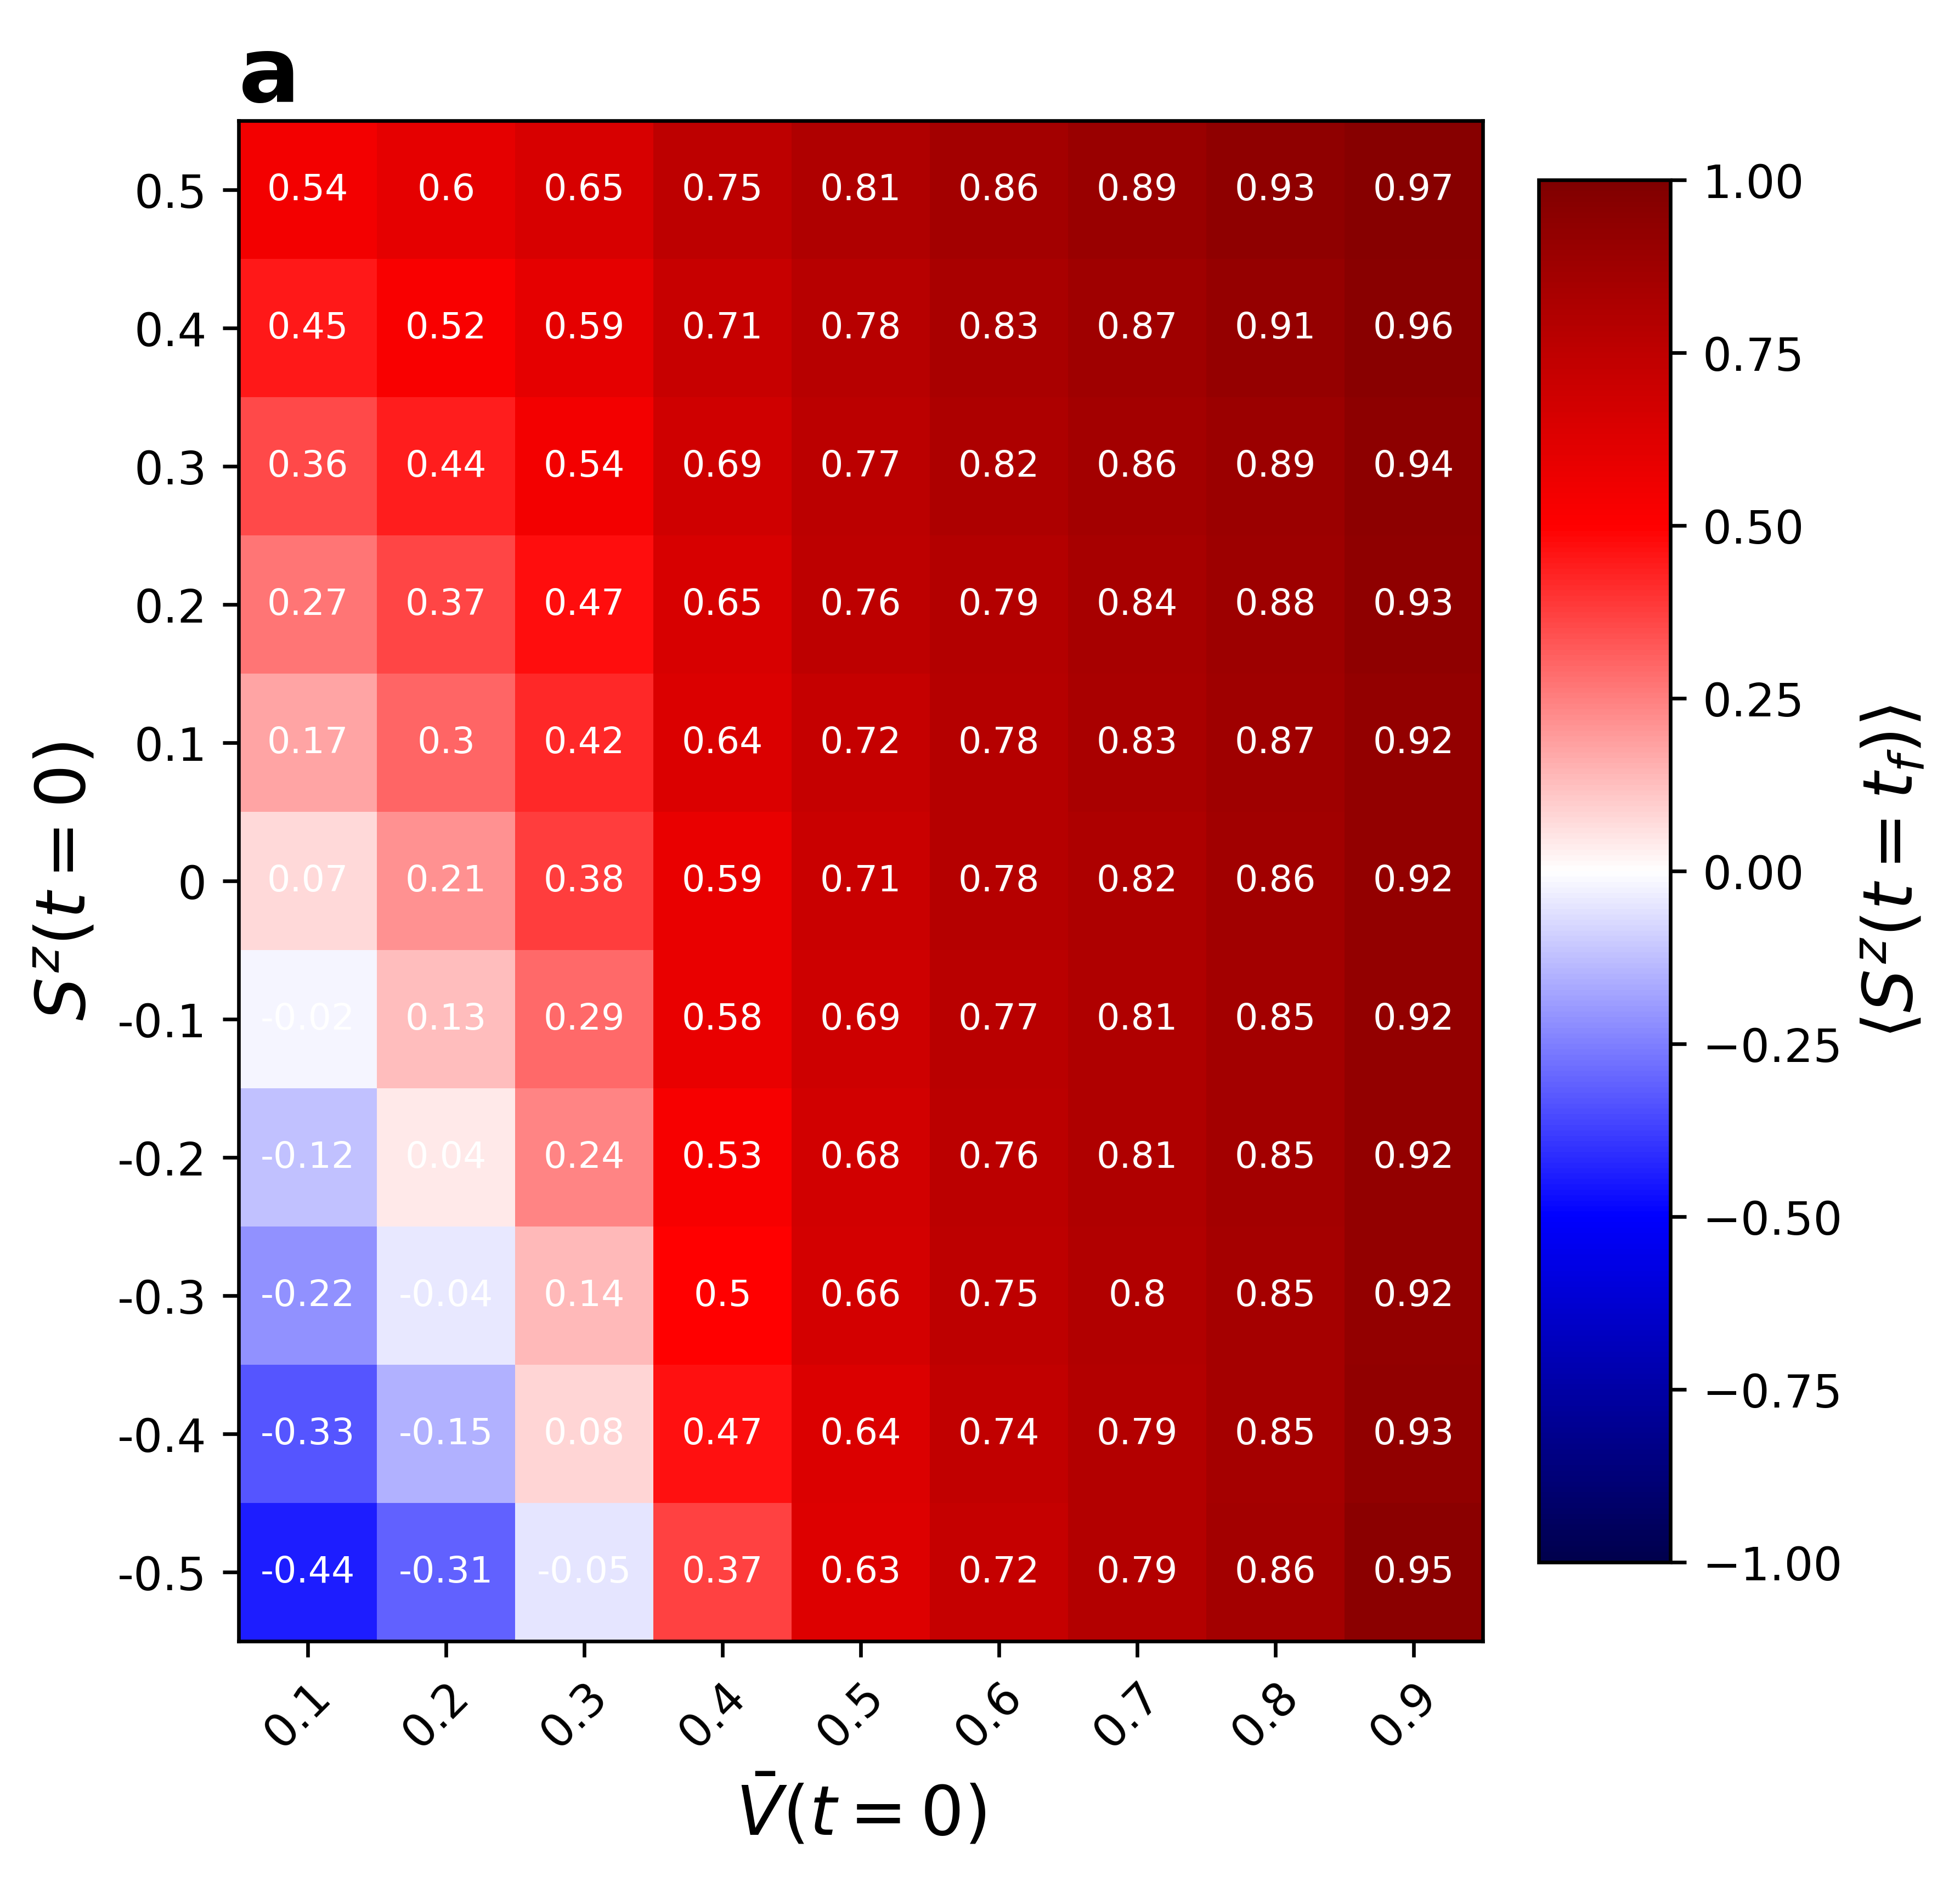

In [16]:
import matplotlib.pyplot as plt

title_font = {
    'fontsize': 20,
    'fontweight': 'bold'
}

fig, axs = plt.subplots(figsize=(8,6), dpi=600)

S_avg = Savg_new
S_std = Sstd_new
V_avg = Vavg_new

row_indices = [-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5]
row_indices.reverse()
column_names = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

im = axs.imshow(S_avg, vmin=-1, vmax=1, cmap='seismic')
# Show all ticks and label them with the respective list entries
axs.set_xticks(np.arange(len(column_names)), labels=column_names)
axs.set_yticks(np.arange(len(row_indices)), labels=row_indices)

# Rotate the tick labels and set their alignment.
plt.setp(axs.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(row_indices)):
    for j in range(len(column_names)):
        text = axs.text(j, i, f'{np.around(S_avg[i, j],2)}', ha="center", va="center", color="w", fontsize=8)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.72, 0.15, 0.05, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
#fig.colorbar(im, cax=cbar_ax, label=r'Final Group Performance ($S_\hat{z}$)')
cbar.set_label(r'$\langle S^z(t=t_f) \rangle$', fontsize=15)

axs.set_xlabel(r'$\bar{V}(t=0)$', fontsize=15)
axs.set_ylabel(r'$S^z(t=0)$', fontsize=15)
axs.set_title('a', fontdict=title_font, loc='left', pad=-5)

#plt.savefig('FigAll_a.png', bbox_inches = 'tight')
#plt.savefig('FigAll_a.pdf', bbox_inches = 'tight')

In [17]:
import matplotlib as mpl

cmap = mpl.colormaps['plasma']

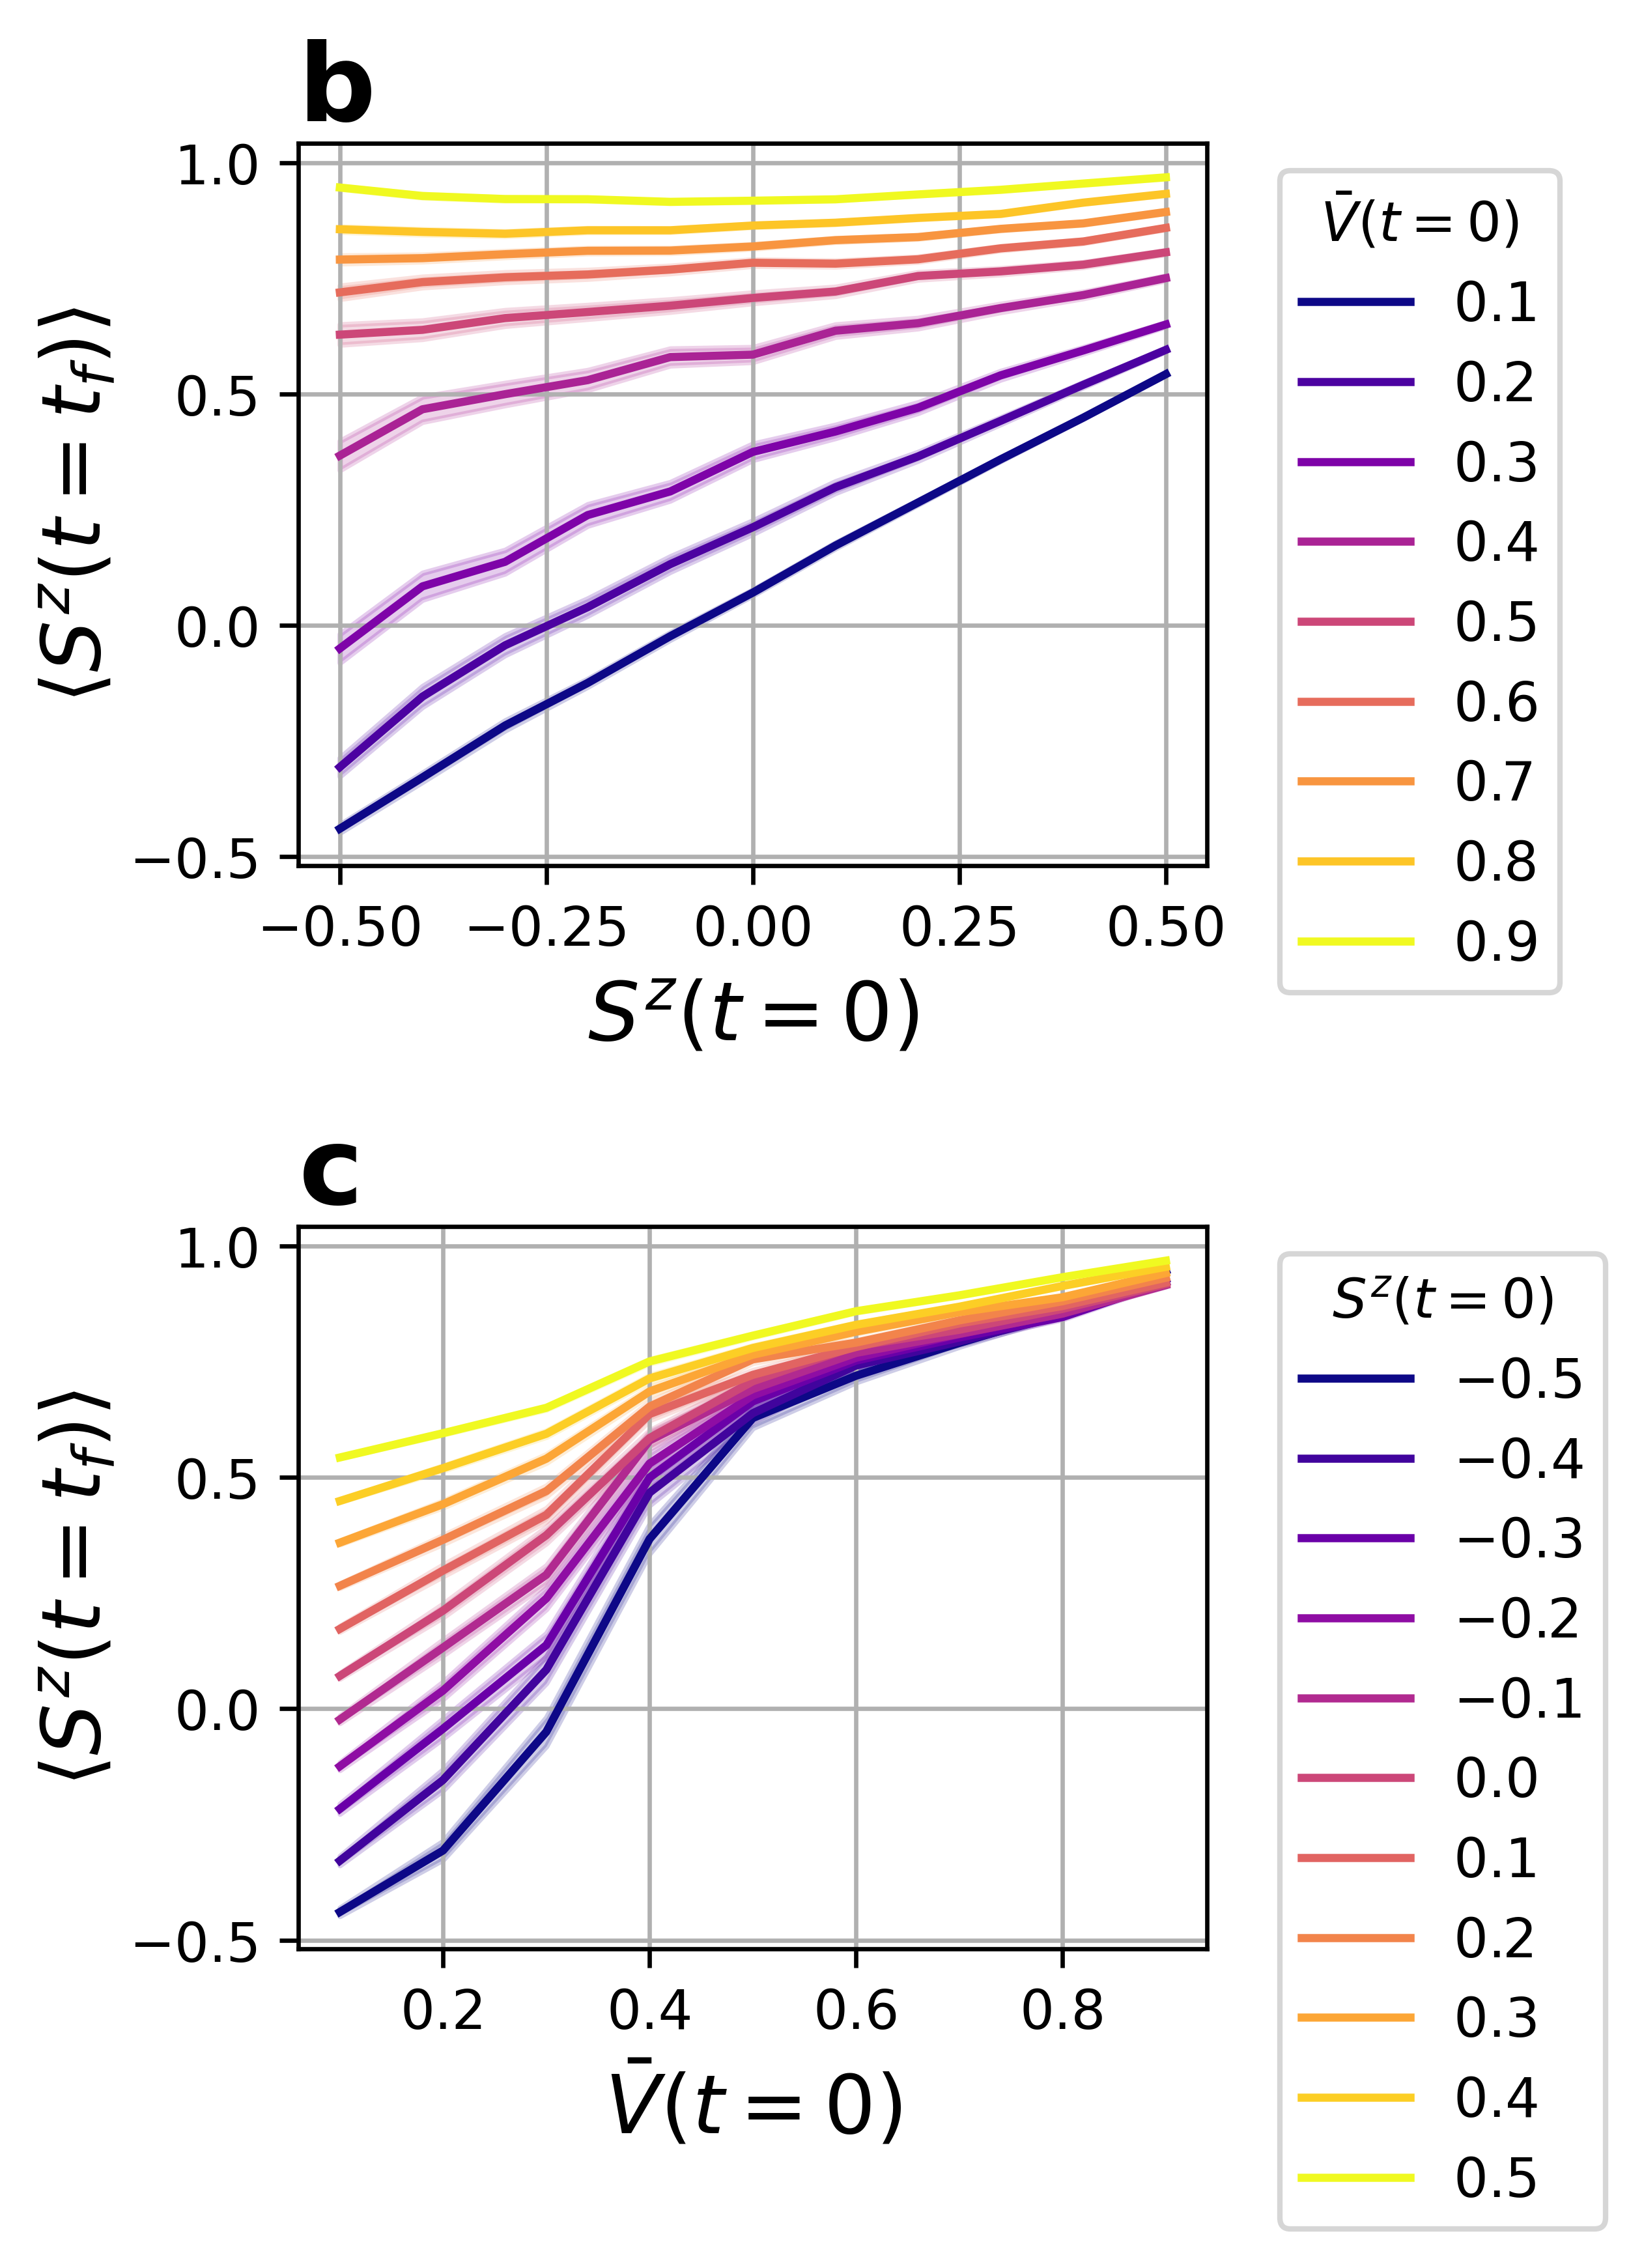

In [21]:
fig,axs = plt.subplots(2,1,figsize=(3,6), dpi=600)
plt.subplots_adjust(hspace=0.5)

GP = [-0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
DO = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6 ,0.7, 0.8, 0.9]

title_font = {
    'fontsize': 20,
    'fontweight': 'bold'
}

# Fix initial DO
colors = cmap(np.linspace(0, 1, len(DO)))
axs[0].set_xlabel(r'$S^z(t=0)$', fontsize=15)
axs[0].set_ylabel(r'$\langle S^z(t=t_f) \rangle$', fontsize=15, labelpad=2)
for idx_do, do in enumerate(DO):
    axs[0].plot(GP, np.flip(Savg_new[:,idx_do]), color=colors[idx_do], label= f'${do}$')
    Savg = np.flip(Savg_new[:,idx_do])
    Sstd = 2*np.flip(Sstd_new[:,idx_do]) 
    axs[0].fill_between(GP, Savg - Sstd, Savg + Sstd, color=colors[idx_do], alpha = 0.2)
axs[0].grid()
axs[0].legend(bbox_to_anchor=(1.05, 1.0), loc="upper left", title=r'$\bar{V}(t=0)$')

# Fix initial GP
colors = cmap(np.linspace(0, 1, len(GP)))
axs[1].set_xlabel(r'$\bar{V}(t=0)$', fontsize=15)
axs[1].set_ylabel(r'$\langle S^z(t=t_f) \rangle$', fontsize=15, labelpad=2)
#axs[1].set_ylabel(r'$S_\hat{z}$', fontsize=15, rotation=0, labelpad=10)
for idx_gp, gp in enumerate(GP):
    axs[1].plot(DO, Savg_new[len(GP)-idx_gp-1,:], color=colors[idx_gp], label= f'${gp}$')
    Savg = Savg_new[len(GP)-idx_gp-1,:]
    Sstd = 2*Sstd_new[len(GP)-idx_gp-1,:]
    axs[1].fill_between(DO, Savg - Sstd, Savg + Sstd, color=colors[idx_gp], alpha = 0.2)
axs[1].grid()
axs[1].legend(bbox_to_anchor=(1.05, 1.0), loc="upper left", title=r'$S^z(t=0)$')

axs[0].set_title('b', fontdict=title_font, loc='left', pad=-5)
axs[1].set_title('c', fontdict=title_font, loc='left', pad=-5)

#plt.savefig('FigAll_b.png', bbox_inches = 'tight')
#plt.savefig('FigAll_b.pdf', bbox_inches = 'tight')

# Surface plot

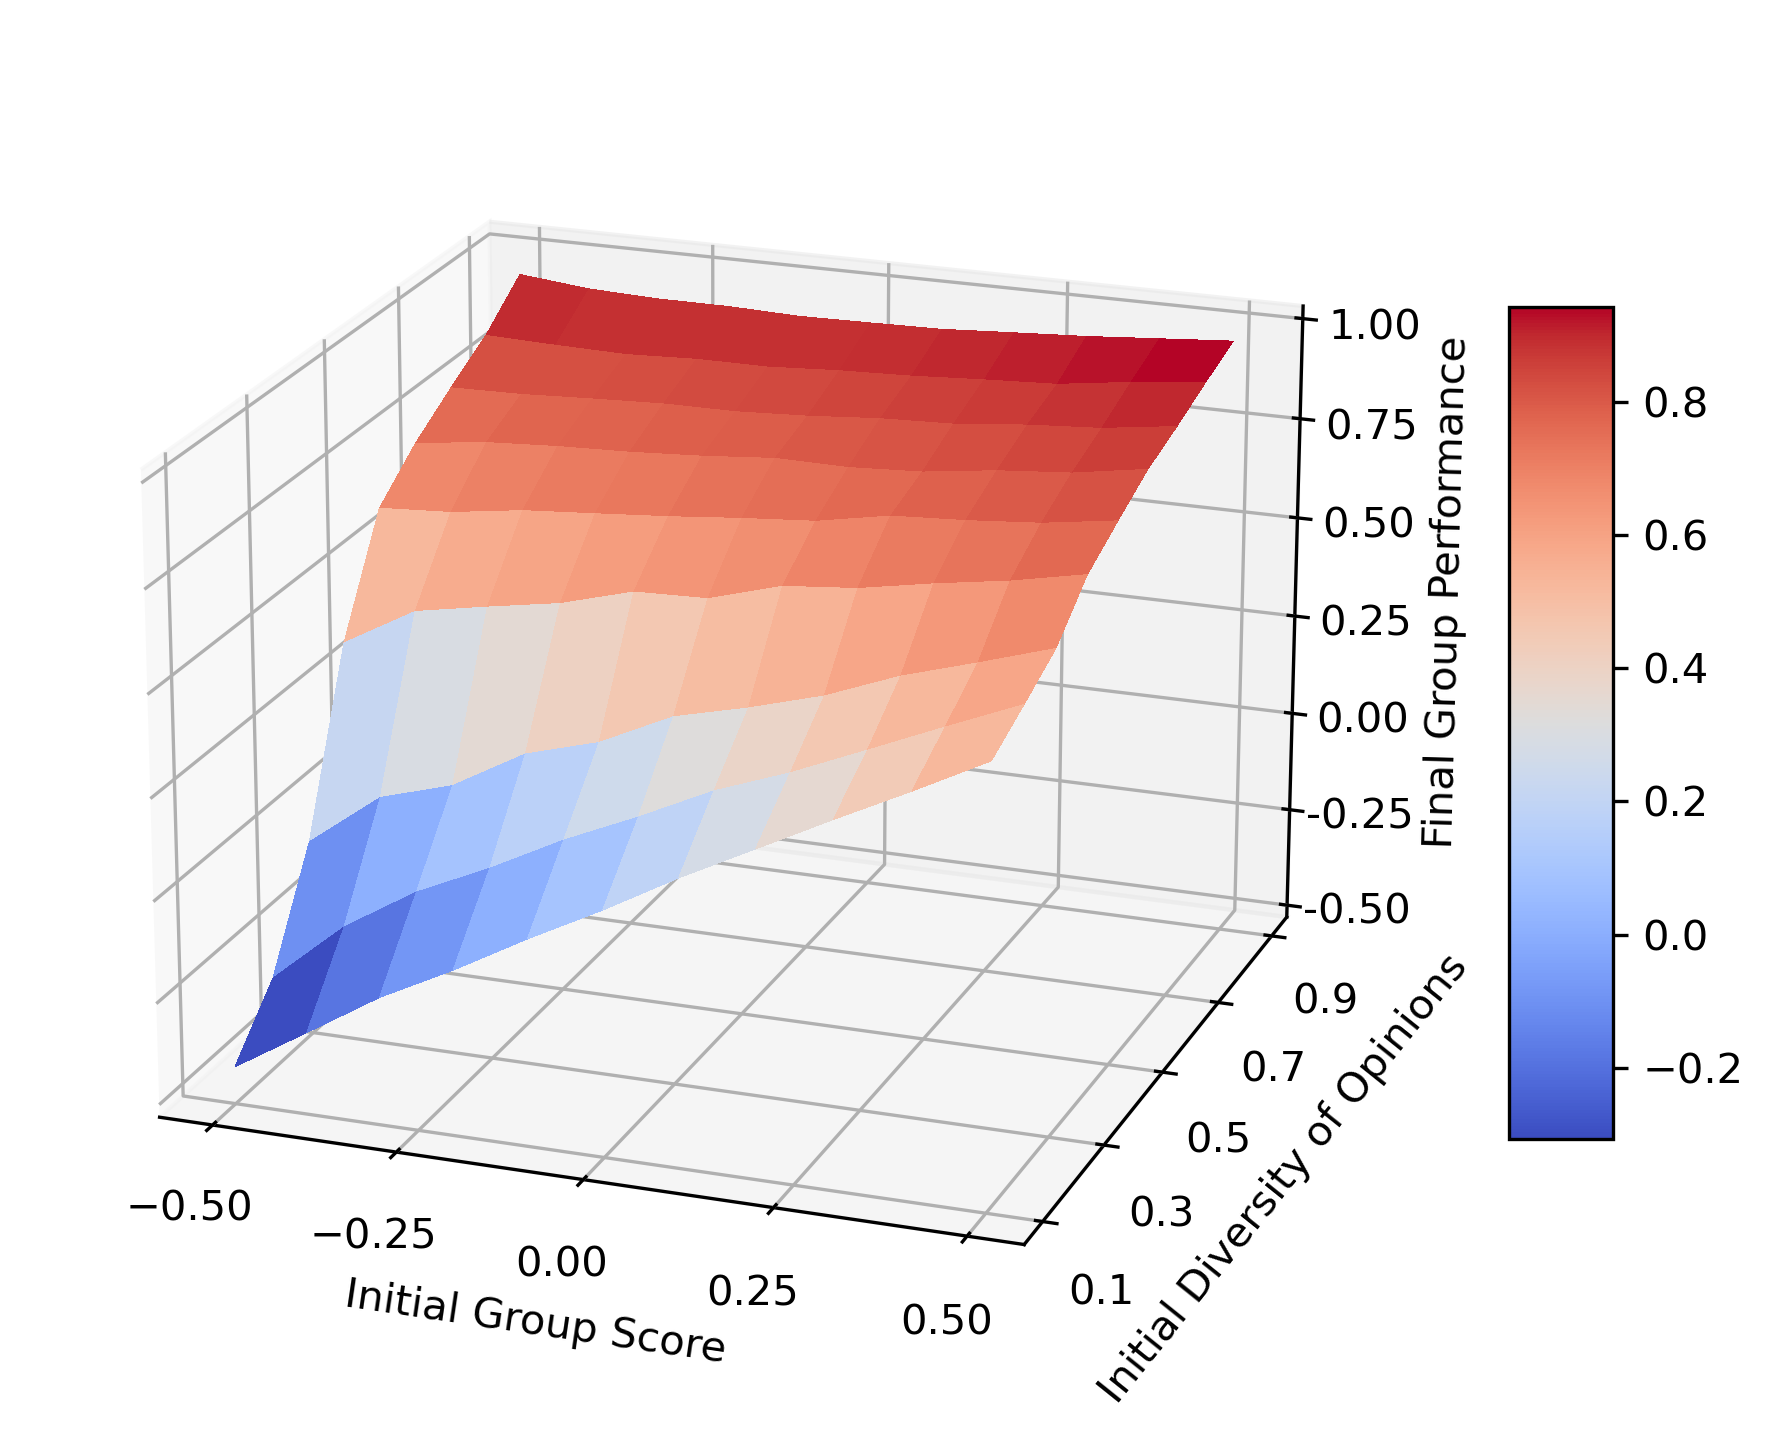

In [31]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(8,6), dpi=300)

# Make data.

row_indices = [-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5]
column_names = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

X = row_indices
Y = column_names
X, Y = np.meshgrid(X, Y)
Z = Savg_df

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_xticks([-0.5, -0.25, 0, 0.25, 0.5])
ax.set_yticks([0.1, 0.3, 0.5, 0.7, 0.9])
ax.set_zticks([-0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1.0])
ax.zaxis.set_major_locator(LinearLocator(7))
ax.view_init(20, 290)

ax.set_xlabel(r'Initial Group Score')
ax.set_ylabel(r'Initial Diversity of Opinions')
ax.set_zlabel('Final Group Performance')

# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.6, aspect=8)

plt.show()